# NDVI Anomaly
<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/NDVI%20Anomaly.png" />
[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)
Product showing change in NDVI between two time periods, the impact of seasonality should be considered.

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob

# Import functions to load and stack data without datacube
from notebook_functions import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44097,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:42865,Total threads: 4
Dashboard: http://127.0.0.1:43805/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:45991,


## Set Up Parameters

In [36]:
# Running locally on landsat 8 data for now
baseline_product = 'landsat_8'
baseline_measurement = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

analysis_product = 'landsat_8'
analysis_measurement = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Viz Bounding Box
viz_coords = {'min_lon':-63.15,
               'min_lat': 18.0,
               'max_lon': -63.0,
               'max_lat': 18.1}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

# Set mosaic type (options: 'median', 'mean', 'max', 'min')
mosaic_type = 'median'

# Set water threshold used to mask water out of the images
water_thresh = 0.3

## Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Run data for St Maarten Baseline
baseline_dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat_baseline/'
baseline_ds = prep_dataset(baseline_dir, baseline_measurement, baseline_product, clip_coords)

## Run data for the Tile7572 baseline
# baseline_dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/BaselineData/'
# baseline_ds = prep_dataset(baseline_dir, baseline_measurement, baseline_product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 4, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2018-11-09 ... 2018-03-14
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000),

In [6]:
# St Maarten Analysis
analysis_dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat_analysis/'
analysis_ds = prep_dataset(analysis_dir, analysis_measurement, analysis_product, clip_coords)

# # Run data for the Tile7572 analysis
# analysis_dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/AnalysisData/'
# analysis_ds = prep_dataset(analysis_dir, analysis_measurement, analysis_product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 3, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2022-11-20 2022-12-22 2022-10-19
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), met

## Cloud and Water Masking
Mask out clouds to look at only clear pixels.

In [18]:
# Use the landsat cloud mask function to mask out clouds.
clean_mask_baseline = ls_cloud_mask(baseline_ds)
clean_mask_analysis = ls_cloud_mask(analysis_ds)

# Use the landsat water mask function to generate water masks for individual scenes.
water_mask_baseline = ls_clean_mask(baseline_ds, keep_water=True)
water_mask_analysis = ls_clean_mask(analysis_ds, keep_water=True)

## Create Composites
These composites are cloud masked, but include water.

In [23]:
def create_temporal_composite(dataset, mosaic_type, clean_mask=None):
    if clean_mask is not None:
        dataset = dataset.where(clean_mask == 1, np.nan)
    
    # Select and run the mosaic type
    if mosaic_type in ['mean']:
        composite = dataset.mean(dim=['time'])
    elif mosaic_type in ['max']:
        composite = dataset.max(dim=['time'])
    elif mosaic_type in ['min']:
        composite = dataset.min(dim=['time'])
    elif mosaic_type in ['median']:
        composite = dataset.median(dim=['time'])
    else:
        print('invalid mosaic')
    
    return composite

# Create composites (summarizing through time) of the baseline and analysis datasets
baseline_composite = create_temporal_composite(baseline_ds, mosaic_type, clean_mask = clean_mask_baseline)
analysis_composite = create_temporal_composite(analysis_ds, mosaic_type, clean_mask = clean_mask_analysis)

### Visualize the Composites

/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


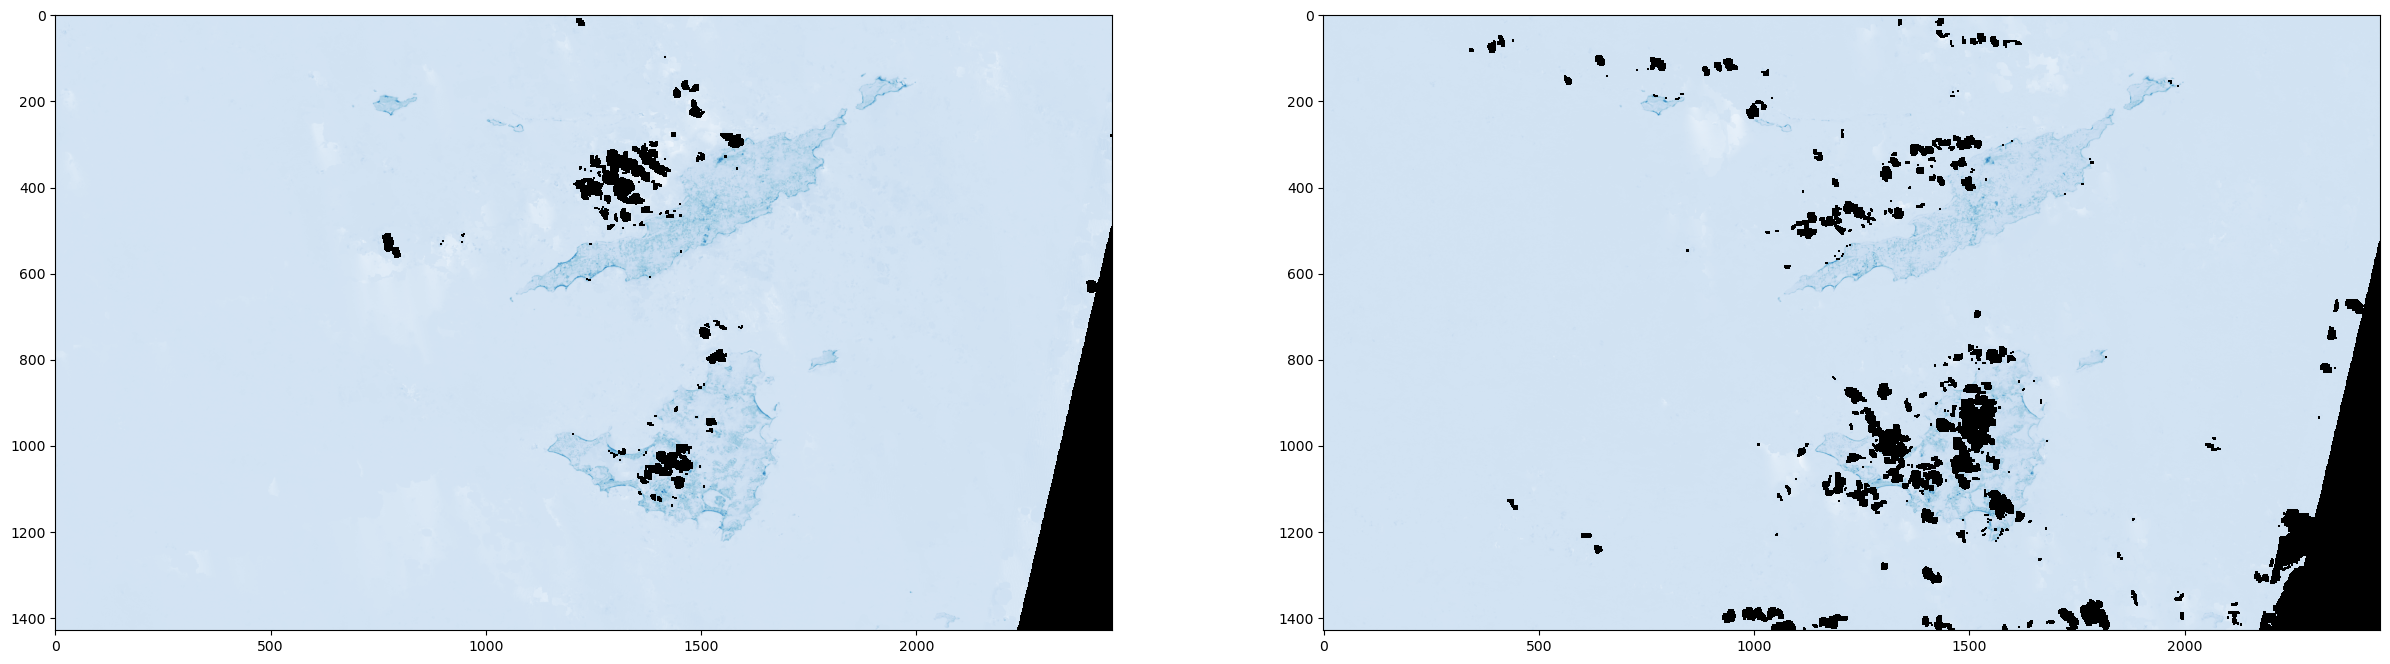

In [24]:
# Plot a band from the composites (e.g. blue)
fig, ax = plt.subplots(1, 2, figsize=(30,30))
cmap = matplotlib.colormaps.get_cmap('Blues')
cmap.set_bad(color='black')
ax[0].imshow(baseline_composite.nir, cmap=cmap)
ax[1].imshow(analysis_composite.nir, cmap=cmap)

## Water Mask
Generate a single water mask for the area of interest by compositing the individual scene water masks over time.

In [26]:
# Generate the water composites to use for water masking 
water_composite_baseline = create_temporal_composite(water_mask_baseline, 'mean')
water_composite_analysis = create_temporal_composite(water_mask_analysis, 'mean')

# Use the composites to mask water out of the baseline and analysis composites
baseline_composite = baseline_composite.where((baseline_composite != np.nan) & (water_composite_baseline <= water_thresh))
analysis_composite = analysis_composite.where((analysis_composite != np.nan) & (water_composite_analysis <= water_thresh))

### Visualize the Water Composites

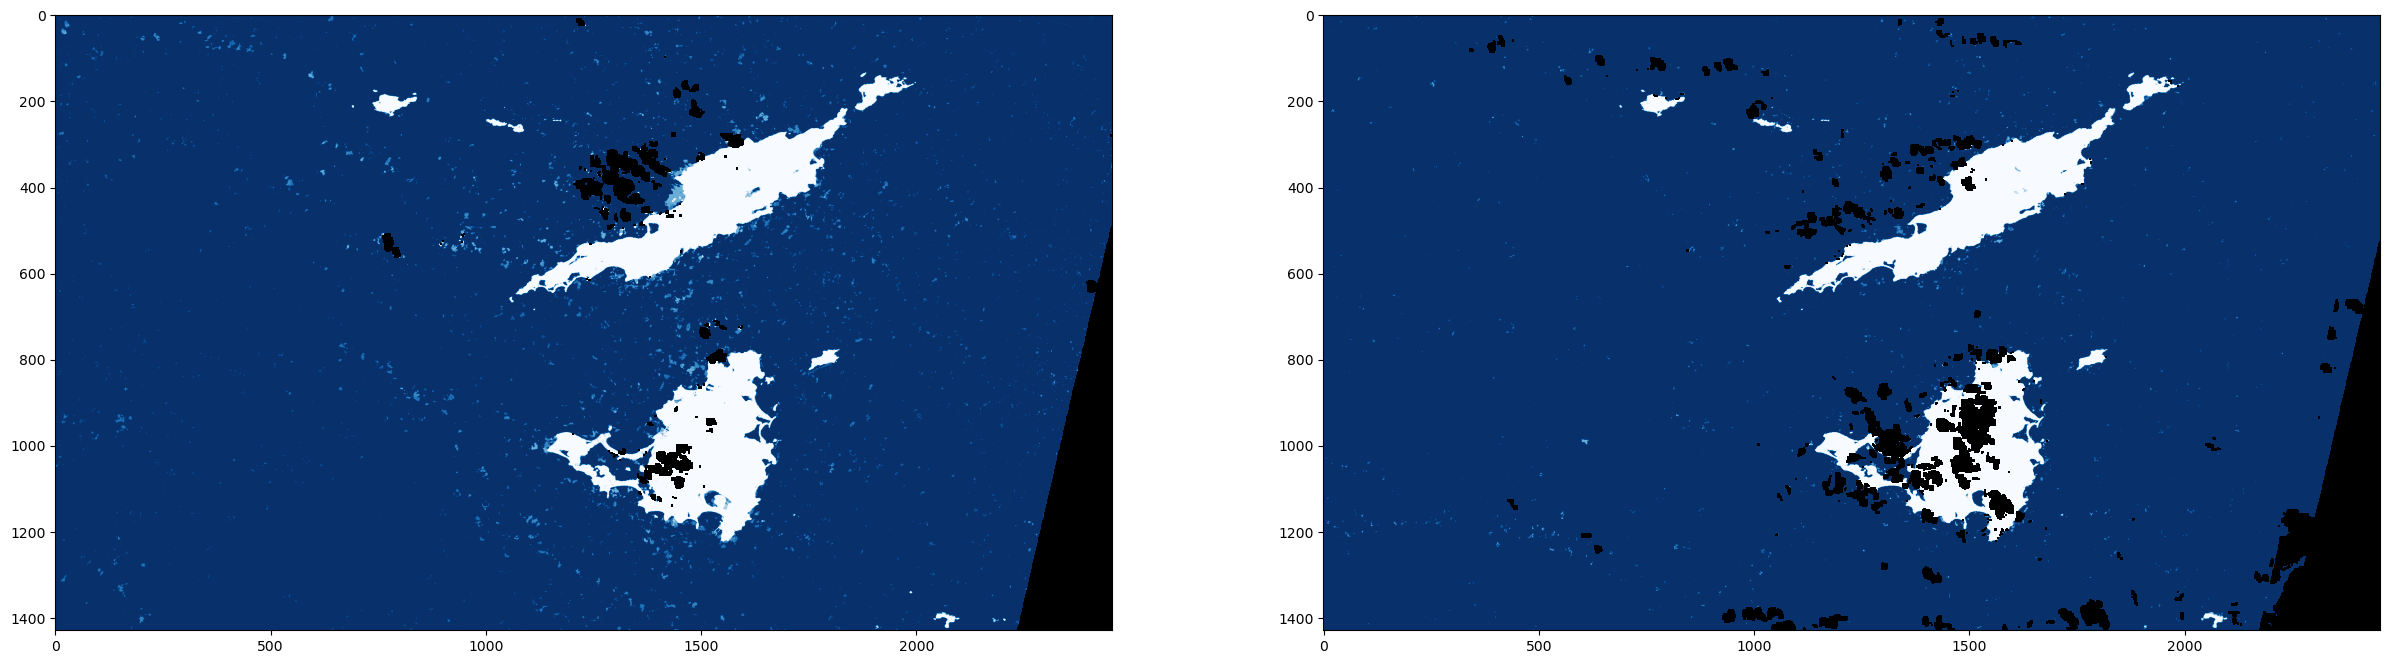

In [22]:
# Plot a band from the composites (e.g. blue)
fig, ax = plt.subplots(1, 2, figsize=(30,30))
cmap = matplotlib.colormaps.get_cmap('Blues')
cmap.set_bad(color='black')
ax[0].imshow(water_composite_baseline, cmap=cmap)
ax[1].imshow(water_composite_analysis, cmap=cmap)

### Visualize Composite Datasets 
The following composites have had both water and clouds masked out so only land should remain. 

/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


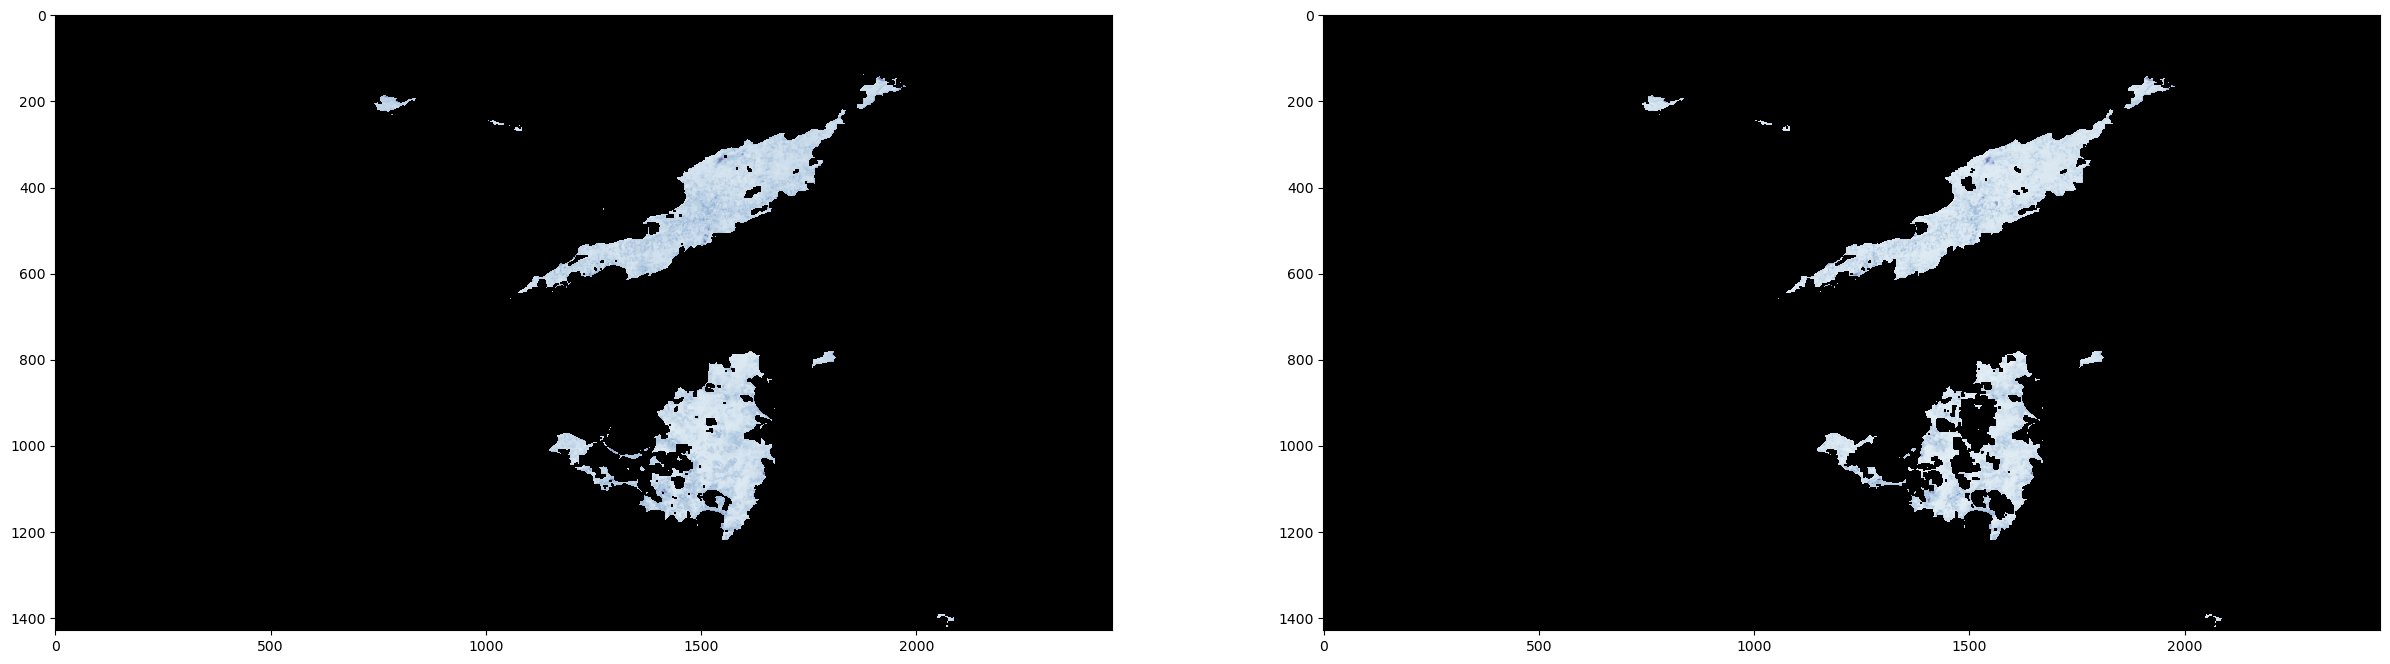

In [28]:
# Plot a band from the composites (e.g. blue)
fig, ax = plt.subplots(1, 2, figsize=(30,30))
cmap = matplotlib.colormaps.get_cmap('BuPu')
cmap.set_bad(color='black')
ax[0].imshow(baseline_composite.nir, cmap=cmap)
ax[1].imshow(analysis_composite.nir, cmap=cmap)

## Calculate NDVI

In [30]:
def NDVI(dataset):
    NDVI = (dataset.nir - dataset.red)/(dataset.nir + dataset.red)
    NDVI = NDVI.where(dataset.nir.notnull() & dataset.red.notnull())
    return NDVI


# Calculate NDVI composite for both datasets
ndvi_baseline_composite = NDVI(baseline_composite)
ndvi_analysis_composite = NDVI(analysis_composite)

# Use stack arrays with composite time handling to align composites before calculations. 
ndvi_analysis_composite, ndvi_baseline_composite = stack_arrays([ndvi_analysis_composite, ndvi_baseline_composite], ndvi_analysis_composite, time_handling='Composites')

### Visualize NDVI Composites

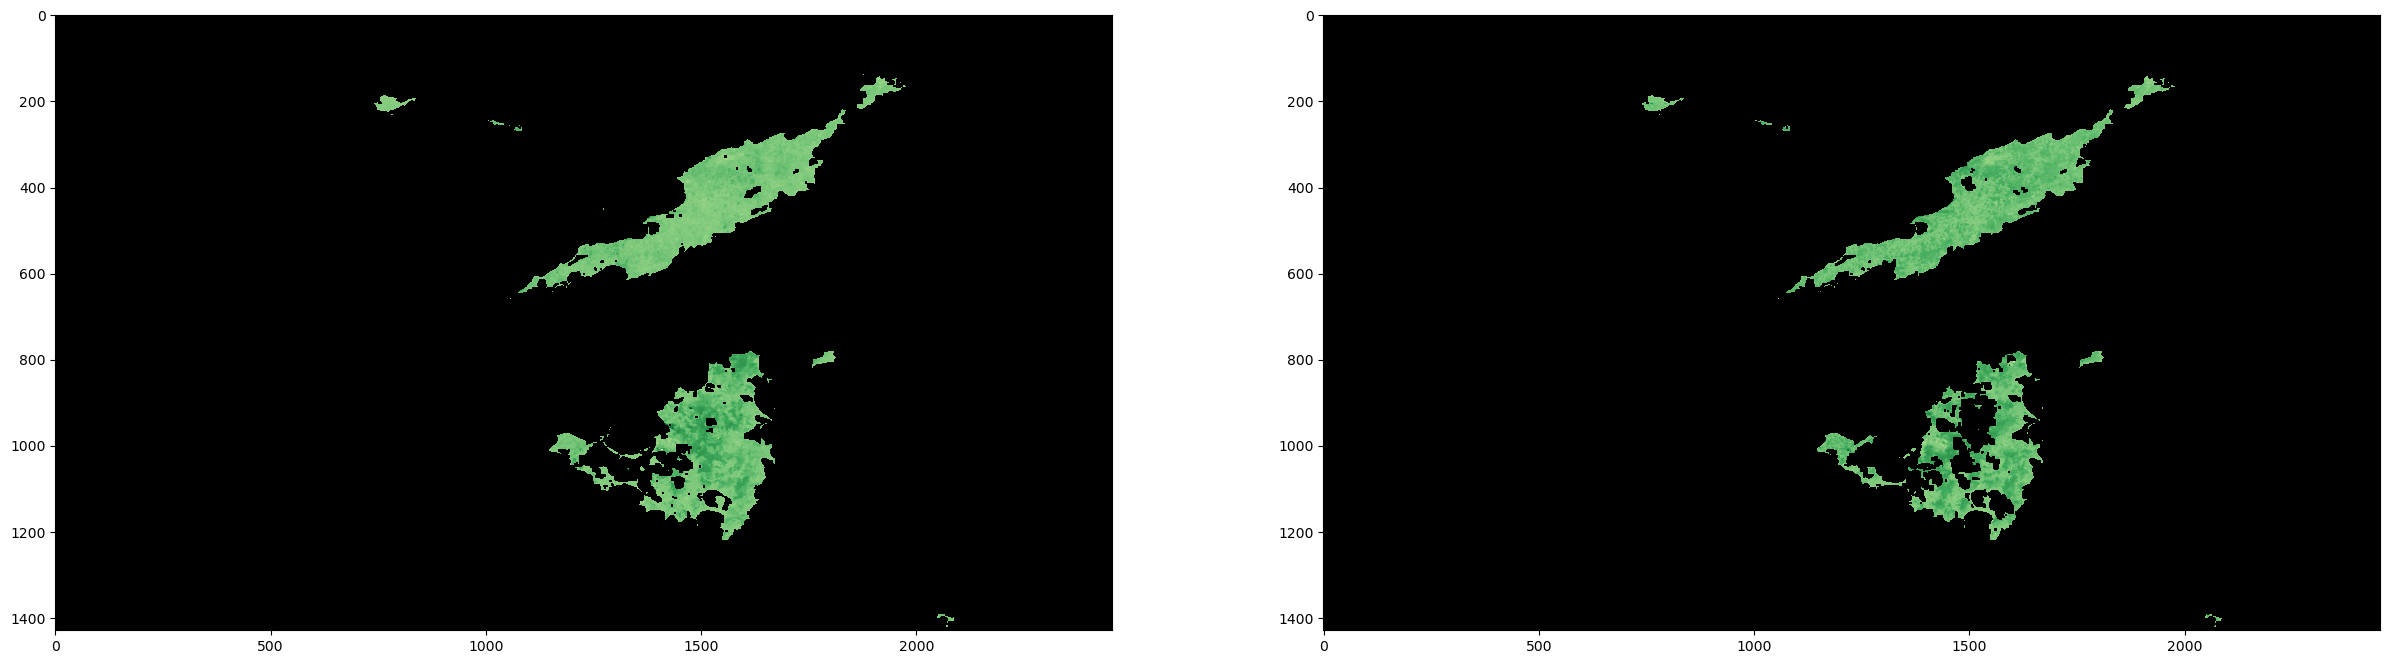

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(30,30))
cmap = matplotlib.colormaps.get_cmap('YlGn_r')
cmap.set_bad(color='black')
ax[0].imshow(ndvi_baseline_composite.squeeze(), cmap=cmap, vmin=-1, vmax=1)
ax[1].imshow(ndvi_analysis_composite.squeeze(), cmap=cmap, vmin=-1, vmax=1)

## NDVI Anomaly

In [32]:
# Calculate NDVI Anomaly.
ndvi_anomaly = ndvi_analysis_composite - ndvi_baseline_composite

### Visualize NDVI Anomaly

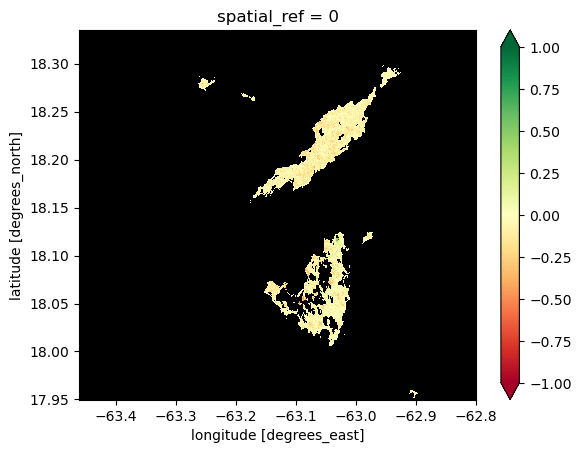

In [34]:
cmap = matplotlib.colormaps.get_cmap('RdYlGn')
cmap.set_bad(color='black')
ndvi_anomaly.plot.imshow(cmap=cmap, vmin=-1, vmax=1)

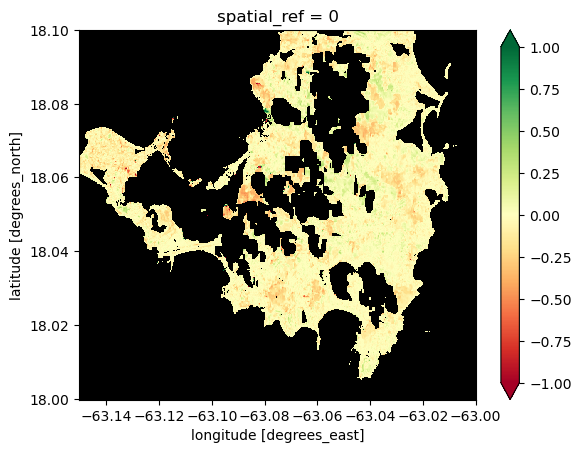

In [37]:
# Subset the data further to highlight Sint Maarten
subset_ndvi_anomaly = ndvi_anomaly.rio.clip_box(minx = viz_coords['min_lon'], miny = viz_coords['min_lat'], 
                                                maxx = viz_coords['max_lon'], maxy = viz_coords['max_lat']) 
subset_ndvi_anomaly.plot.imshow(cmap=cmap, vmin=-1, vmax=1)

## Export Desired Data

In [ ]:
ndvi_analysis_composite.rio.to_raster(f"StMaarten_NDVI_Analysis_Composite.tif", dtype="float32", driver='COG')
ndvi_baseline_composite.rio.to_raster(f"StMaarten_NDVI_Baseline_Composite.tif", dtype="float32", driver='COG')
ndvi_anomaly.rio.to_raster(f"StMaarten_NDVIAnomaly.tif", dtype="float32", driver='COG')